- 시퀀스 투 시퀀스(Sequence to Sequence)
  - 입력시퀀스를 받아서 출력 시퀀스로 변환
  - 자연어처리, 기계번역, 문장요약, 쳇봇
  - 인코더 : 입력시퀀스를 고정된 크기의 벡터로 인코딩
    - LSTM, GRU 구조를 사용하고 입력시퀀스를 순차적으로 읽는다(문장) -> 고정된 크기의 컨덱스트 벡터로 변환: 입력시퀀스의 의미를 압축한 형태
  - 디코더 : 출력 시퀀스
    - RNN,LSTM,GRU등의 구조를 사용 출력단어는 이전 출력단어에 의존해서 순차적으로 생성
  
  - 번역의 예
    - 입력시퀀스 : I LOVE YOU
      - 인코더 : 단어단위로 처리해서 고정된 크기의 벡터("I LOVE YOU"를 압축한 형태)
    - 출력시퀀스 : 당신을 사랑합니다.
      - 첫번째 출력은 "나는" 두번째는 "당신을", 마지막 "사랑해"

  - 한계
    - 입력시퀀스를 고정된 벡터로 압축해서 전달하면.. 시퀀스가 길어지면 정보손실 --> 어텐션 도입
    - 모든 단계의 출력에 가중치를 부여해서 디코더가 특정 부위에 더 집중 할 수 있도록 만듦



In [1]:
import gdown
file_id = '1aU4FWR61LCoNXfYJzfrh4D9xi55gmu9b'
download_url = f'https://drive.google.com/uc?id={file_id}'
gdown.download(download_url, 'data.csv', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1aU4FWR61LCoNXfYJzfrh4D9xi55gmu9b
To: /content/data.csv
100%|██████████| 890k/890k [00:00<00:00, 59.7MB/s]


'data.csv'

In [2]:
!pip install konlpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 kB 29.3 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
from collections import Counter
from konlpy.tag import Okt

In [4]:
data = pd.read_csv('data.csv')
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [5]:
# 전처리하고 분석에 활용하기위해서 하나의 문장으로 합치기
sentence = (data['Q'] + data['A'])
sentence[:3]

,0
0,12시 땡!하루가 또 가네요.
1,1지망 학교 떨어졌어위로해 드립니다.
2,3박4일 놀러가고 싶다여행은 언제나 좋죠.


In [6]:
# 공백을 기준으로 분할해서 단어단위로 토큰화
tokenized_sentence = [ i.split() for i in sentence]
# 단어의 개수를 카운트 : 문장의 길이를 단어(토크)기준 계산 모델을 훈련할때 필요한 최대 문장길이를 설정하기 위해서 필요
sent_len_by_token = [len(i) for i in tokenized_sentence]
# sentence에서 공백을 제거, 음절단위로 문장의 길이를 계산 : 단어가 아닌 음절(한글의 자모로 구성된 최소 단위)
sent_len_by_eumjeol = [len(i.replace(' ','')) for i in sentence]
okt = Okt()
# 형태소 단위로 토큰화 : 한국어의 특징을 더 잘 반영
morph_tokenized_sentence = [okt.morphs(i) for i in sentence]
# 형태소 단위로 토큰화의 길이
sent_len_by_morph = [len(i) for i in morph_tokenized_sentence]

In [7]:
# 시각화는 교재를 참고해서 만들어 볼것

In [8]:
# 형태소
print(f'문장 : {sentence[0]}')
okt.pos(sentence[0]) # 형태소 품사정보를  반환

문장 : 12시 땡!하루가 또 가네요.


[('12시', 'Number'),
 ('땡', 'Noun'),
 ('!', 'Punctuation'),
 ('하루', 'Noun'),
 ('가', 'Josa'),
 ('또', 'Noun'),
 ('가네요', 'Verb'),
 ('.', 'Punctuation')]

In [9]:
query_sentence = list(data['Q'])
answer_sentence = list(data['A'])
query_NVA_token_sentences, answer_NVA_token_sentences = [],[]
for s in query_sentence:
  for token, tag in okt.pos(s):
    # 명사, 동사, 형용사 확인
    if tag in ['Noun','Verb','Adjective']:  # 필요없는 품사를 제외하고 의미있는 품사만 추
      query_NVA_token_sentences.append(token)
for s in answer_sentence:
  for token, tag in okt.pos(s):
    if tag in ['Noun','Verb','Adjective']:
      answer_NVA_token_sentences.append(token)

query_NVA_token_sentences = ' '.join(query_NVA_token_sentences)
answer_NVA_token_sentences = ' '.join(answer_NVA_token_sentences)

In [10]:
query_NVA_token_sentences

'땡 지망 학교 떨어졌어 박 놀러 가고 싶다 박 정도 놀러 가고 싶다 심하네 카드 망가졌어 카드 돼 맞팔 왜 하지 시간 낭비 거 아는데 매일 하는 중 시간 낭비 자꾸 보게 됨 보면 나 빼고 행복 해보여 가끔 궁금해 가끔 뭐 하는지 궁금해 가끔 혼자 좋다 가난한 자의 설움 있어도 땀 난다 가상 화폐 쫄딱 망함 가스 불 켜고 나갔어 가스 불 켜놓고 나온거 같아 가스 비 나왔다 가스 비 비싼데 감기 걸리겠어 가스 비 장난 아님 가장 확실한 건 뭘 까 가족 여행 가기 했어 가족 여행 고고 가족 여행 어디 가지 가족 있어 가족 관계 알려 줘 가족 끼리 여행 간다 가족 보고 싶어 가족 서먹해 가족 서먹해졌어 가족 어디 가지 가족 여행 갈거야 가족 여행 가야 가족 누구 가족 여행 가려고 가족 스트레스 풀었어 가출 할까 가출 해도 갈 데 없어 간만 떨리니까 좋더라 간만 쇼핑 중 간만 휴식 중 간식 뭐 먹을까 간식 추천 간장 치킨 시켜야지 간접흡연 싫어 갈까 말까 고민 돼 갈까 말까 감 말랭이 먹고 싶다 감 말랭이 먹어야지 감기 같 애 감기 걸린 것 같아 감기 기운 있어 감기 들 거 같 애 감기 오려나 감기 약 없어 감기 같 애 감미로운 목소리 좋아 감정 쓰레기통 엉망 진창 감정 컨트롤 하겠어 감정 컨트롤 돼 감히 나를 무시 하는 애가 있어 갑자기 나쁜 생각 막 들더라 갑자기 눈물 나 갑자기 물어봐서 당황 했어 갑자기 불편한 사이 된 거 같아 강렬한 첫인상 남겨야 하는데 강아지 키우고 싶어 강아지 키우고 싶은데 역시 돼겠지 강아지 키울 수 있을까 강아지 키울까 강원도 가서 살까 게임 하자고 해도 되나 놀러 갈 친구 없어 먹었는데 나 살찐 거 같아 수영장 가기 했어 있으면 힘든데 붙잡고 싶어 피 씨방 가자고 해볼까 할 수 있는 취미 생활 뭐 있을까 개강 입어볼까 개강 옷 예쁘게 입어 볼까 개강 개강 개 같은 상황 개 되 버렸어 개 기름 꼈어 개념 놓고 옴 개념 없어 개 당황 개 당황 했잖아 갑자기 물어 봐서 개인 업무 시켜 개인 일도 시켜 개 졸려 개 좋아 개학 좋다 걔 싫다 

In [11]:
answer_NVA_token_sentences

'하루 또 가네요 위로 해 드립니다 여행 좋죠 여행 좋죠 눈살 찌푸려지죠 다시 새로 사는 게 마음 편해요 다시 새로 사는 게 마음 편해요 잘 모르고 있을 수도 있어요 시간 정 해보세요 시간 정 해보세요 자랑 하는 자리 요 그 사람 그럴 거 그 사람 그럴 거 혼자 즐기세요 돈 다시 들어올 거 땀 식혀주세요 어서 잊고 출발 하세요 집 돌아가서 끄고 나오세요 집 돌아가서 끄고 나오세요 다음 달 더 절약 해봐요 따뜻하게 사세요 다음 달 더 절약 해봐요 가장 확실한 시간 오늘이 어제 내일 놓고 고민 하느라 시간 낭비하지 마세요 온 가족 모두 마음 드는 곳 가보세요 온 가족 모두 마음 드는 곳 가보세요 온 가족 모두 마음 드는 곳 가보세요 저 만들어 준 사람 부모님 저 이야기 해 주는 사람 친구 생각 있어요 저 만들어 준 사람 부모님 저 이야기 해 주는 사람 친구 생각 있어요 더 가까워질 기회 되겠네요 도 들 바빠서 이야기 할 시간 부족했나 봐요 들 바빠서 이야기 할 시간 부족했나 봐요 온 가족 모두 마음 드는 곳 가보세요 좋은 생각 더 가까워질 기회 되겠네요 저 만들어 준 사람 부모님 저 이야기 해 주는 사람 친구 생각 있어요 좋은 생각 정말 후회 할 습관 무모한 결정 리지 마세요 선생님 기관 연락 해보세요 떨리는 감정 그 자체 소중해요 득템 했길 바라요 휴식 필요하죠 단 짠으로 두 개 사는게 진리 단 짠으로 두 개 사는게 진리 맛있게 드세요 저 싫어요 가세 가세 맛있게 드세요 맛있게 드세요 병원 가세 이럴 때 잘 쉬는 게 중요해요 이럴 때 잘 쉬는 게 중요해요 이럴 때 잘 쉬는 게 중요해요 따뜻하게 관리 하세요 병원 가세 병원 가세 저 듣고 싶네요 자신 더 사랑 해주세요 습관 습관 콕 집어서 물어보세요 좋은 생각 하세요 마음 아픈가요 갑작스러웠나 봐요 관계 변화 왔나 봅니다 처음 중요해요 당신 매력 어필 해보세요 책임질 수 있을 때 키워 보세요 먼저 생활 패턴 살펴 보세요 먼저 생활 패턴 살펴 보세요 책임질 수 있을 때 키워 보세요 아름다운 곳 안 될 것 없죠 혼자 

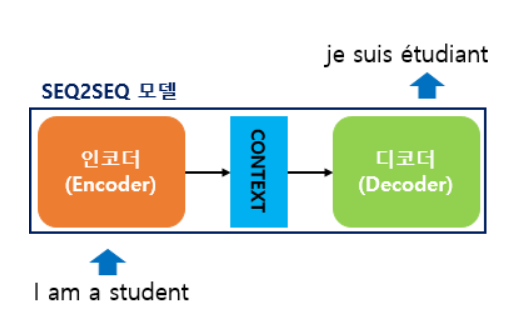

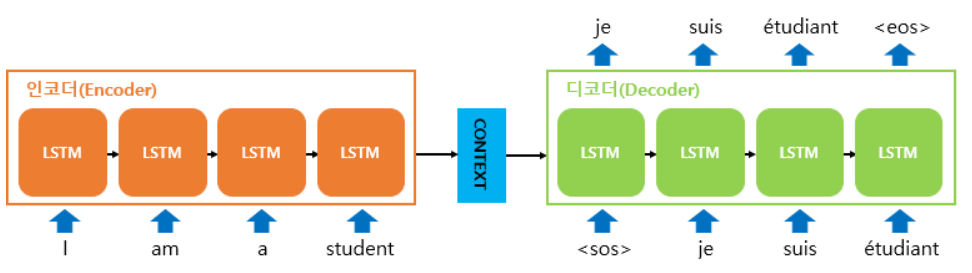

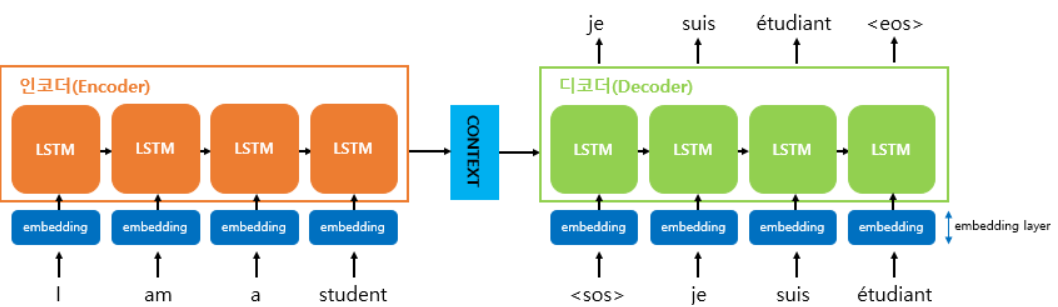

- seq2seq에서 사용되는 모드 단어는 워드임베딩을 통해서 임베딩 벡터로 표현된 벡터


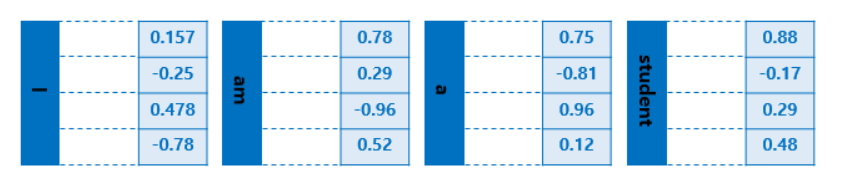

- 전처리

In [12]:
import gdown
file_id = '1rZyJfHvr66Gcn0yRWxts-1w6zKLEYDhp'
download_url = f'https://drive.google.com/uc?id={file_id}'
gdown.download(download_url, 'data_short.csv', quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1rZyJfHvr66Gcn0yRWxts-1w6zKLEYDhp
To: /content/data_short.csv
100%|██████████| 1.45k/1.45k [00:00<00:00, 5.02MB/s]


'data_short.csv'

In [13]:
data_short = pd.read_csv('data_short.csv')
data_short.shape

(20, 3)

In [14]:
# 질문과 답변 데이터를 처리한다음 시퀀스 투 시퀀스 모델을 위해서 입출력을 담당하는 라이브러리를 생성
# 데이터로드, 단어를 토큰, 사전을 생성, 데이터를인덱스로 변환과정

In [15]:
import string
FILTER = string.punctuation
PAD = "<PAD>"  # 패딩
STD = "<SOS>"
END = '<END>'
UNK = '<UNK>'  # 사전에 없는단어
PAD_INDEX = 0
STD_INDEX = 1
END_INDEX = 2
UNK_INDEX = 3
MARKER = [PAD,STD,END,UNK]
MAX_SEQUENCE = 25  # 이거보다 크면 자르고 짧으면 패딩으로 채운다
# load_data(path)  csv 를 읽어서 질문과 답변 question, answer
# data_tokenizer(data) 특수문자를 제거 단어를 토큰으로 나눠서 리스트에 저장
# prepro_like_morphlized(data) 형태소 분석기를사용해서 문장을 형태소 단위로 나눈다
# load_vocabulary(path,vocab_size,tokenize_as_morph=False) 사전을 생성하거나 불러온다 학습에 사용할 단어사전만들거나 불러올때
# make_vocabulary(vocabulary_list) 단어 리스트 seq2idx(단어->인덱스), idx2seq(인덱스->단어) 딕셔너리
# enc_processing(value,dictionary, tokenize_as_morph=False) 문장을 인덱스로 변환
# dec_output_processing(value, dictionary, tokenize_as_morph=False) 디코더의 입력데이터를 인덱스
# dec_target_processing(value, dictionary, tokenize_as_morph=False) 디코더의 타겟(출력) 인덱
import re
import os
import json
import pandas as pd
import numpy as np
from tqdm import tqdm
from konlpy.tag import Okt


FILTERS = "([~.,!?\"':;)(])"
PAD = "<PAD>"
STD = "<SOS>"
END = "<END>"
UNK = "<UNK>"

PAD_INDEX = 0
STD_INDEX = 1
END_INDEX = 2
UNK_INDEX = 3

MARKER = [PAD, STD, END, UNK]
CHANGE_FILTER = re.compile(FILTERS)

MAX_SEQUENCE = 25


def load_data(path):
    # 판다스를 통해서 데이터를 불러온다.
    data_df = pd.read_csv(path, header=0)
    # 질문과 답변 열을 가져와 question과 answer에 넣는다.
    question, answer = list(data_df['Q']), list(data_df['A'])

    return question, answer


def data_tokenizer(data):
    # 토크나이징 해서 담을 배열 생성
    words = []
    for sentence in data:
        # FILTERS = "([~.,!?\"':;)(])"
        # 위 필터와 같은 값들을 정규화 표현식을
        # 통해서 모두 "" 으로 변환 해주는 부분이다.
        sentence = re.sub(CHANGE_FILTER, "", sentence)
        for word in sentence.split():
            words.append(word)
    # 토그나이징과 정규표현식을 통해 만들어진
    # 값들을 넘겨 준다.
    return [word for word in words if word]


def prepro_like_morphlized(data):
    morph_analyzer = Okt()
    result_data = list()
    for seq in tqdm(data):
        morphlized_seq = " ".join(morph_analyzer.morphs(seq.replace(' ', '')))
        result_data.append(morphlized_seq)

    return result_data


def load_vocabulary(path, vocab_path, tokenize_as_morph=False):
    # 사전을 담을 배열 준비한다.
    vocabulary_list = []
    # 사전을 구성한 후 파일로 저장 진행한다.
    # 그 파일의 존재 유무를 확인한다.
    if not os.path.exists(vocab_path):
        # 이미 생성된 사전 파일이 존재하지 않으므로
        # 데이터를 가지고 만들어야 한다.
        # 그래서 데이터가 존재 하면 사전을 만들기 위해서
        # 데이터 파일의 존재 유무를 확인한다.
        if (os.path.exists(path)):
            # 데이터가 존재하니 판단스를 통해서
            # 데이터를 불러오자
            data_df = pd.read_csv(path, encoding='utf-8')
            # 판다스의 데이터 프레임을 통해서
            # 질문과 답에 대한 열을 가져 온다.
            question, answer = list(data_df['Q']), list(data_df['A'])
            if tokenize_as_morph:  # 형태소에 따른 토크나이져 처리
                question = prepro_like_morphlized(question)
                answer = prepro_like_morphlized(answer)
            data = []
            # 질문과 답변을 extend을
            # 통해서 구조가 없는 배열로 만든다.
            data.extend(question)
            data.extend(answer)
            # 토큰나이져 처리 하는 부분이다.
            words = data_tokenizer(data)
            # 공통적인 단어에 대해서는 모두
            # 필요 없으므로 한개로 만들어 주기 위해서
            # set해주고 이것들을 리스트로 만들어 준다.
            words = list(set(words))
            # 데이터 없는 내용중에 MARKER를 사전에
            # 추가 하기 위해서 아래와 같이 처리 한다.
            # 아래는 MARKER 값이며 리스트의 첫번째 부터
            # 순서대로 넣기 위해서 인덱스 0에 추가한다.
            # PAD = "<PADDING>"
            # STD = "<START>"
            # END = "<END>"
            # UNK = "<UNKNWON>"
            words[:0] = MARKER
        # 사전을 리스트로 만들었으니 이 내용을
        # 사전 파일을 만들어 넣는다.
        with open(vocab_path, 'w', encoding='utf-8') as vocabulary_file:
            for word in words:
                vocabulary_file.write(word + '\n')

    # 사전 파일이 존재하면 여기에서
    # 그 파일을 불러서 배열에 넣어 준다.
    with open(vocab_path, 'r', encoding='utf-8') as vocabulary_file:
        for line in vocabulary_file:
            vocabulary_list.append(line.strip())

    # 배열에 내용을 키와 값이 있는
    # 딕셔너리 구조로 만든다.
    char2idx, idx2char = make_vocabulary(vocabulary_list)
    # 두가지 형태의 키와 값이 있는 형태를 리턴한다.
    # (예) 단어: 인덱스 , 인덱스: 단어)
    return char2idx, idx2char, len(char2idx)


def make_vocabulary(vocabulary_list):
    # 리스트를 키가 단어이고 값이 인덱스인
    # 딕셔너리를 만든다.
    char2idx = {char: idx for idx, char in enumerate(vocabulary_list)}
    # 리스트를 키가 인덱스이고 값이 단어인
    # 딕셔너리를 만든다.
    idx2char = {idx: char for idx, char in enumerate(vocabulary_list)}
    # 두개의 딕셔너리를 넘겨 준다.
    return char2idx, idx2char


def enc_processing(value, dictionary, tokenize_as_morph=False):
    # 인덱스 값들을 가지고 있는
    # 배열이다.(누적된다.)
    sequences_input_index = []
    # 하나의 인코딩 되는 문장의
    # 길이를 가지고 있다.(누적된다.)
    sequences_length = []
    # 형태소 토크나이징 사용 유무
    if tokenize_as_morph:
        value = prepro_like_morphlized(value)

    # 한줄씩 불어온다.
    for sequence in value:
        # FILTERS = "([~.,!?\"':;)(])"
        # 정규화를 사용하여 필터에 들어 있는
        # 값들을 "" 으로 치환 한다.
        sequence = re.sub(CHANGE_FILTER, "", sequence)
        # 하나의 문장을 인코딩 할때
        # 가지고 있기 위한 배열이다.
        sequence_index = []
        # 문장을 스페이스 단위로
        # 자르고 있다.
        for word in sequence.split():
            # 잘려진 단어들이 딕셔너리에 존재 하는지 보고
            # 그 값을 가져와 sequence_index에 추가한다.
            if dictionary.get(word) is not None:
                sequence_index.extend([dictionary[word]])
            # 잘려진 단어가 딕셔너리에 존재 하지 않는
            # 경우 이므로 UNK(2)를 넣어 준다.
            else:
                sequence_index.extend([dictionary[UNK]])
        # 문장 제한 길이보다 길어질 경우 뒤에 토큰을 자르고 있다.
        if len(sequence_index) > MAX_SEQUENCE:
            sequence_index = sequence_index[:MAX_SEQUENCE]
        # 하나의 문장에 길이를 넣어주고 있다.
        sequences_length.append(len(sequence_index))
        # max_sequence_length보다 문장 길이가
        # 작다면 빈 부분에 PAD(0)를 넣어준다.
        sequence_index += (MAX_SEQUENCE - len(sequence_index)) * [dictionary[PAD]]
        # 인덱스화 되어 있는 값을
        # sequences_input_index에 넣어 준다.
        sequences_input_index.append(sequence_index)
    # 인덱스화된 일반 배열을 넘파이 배열로 변경한다.
    # 이유는 텐서플로우 dataset에 넣어 주기 위한
    # 사전 작업이다.
    # 넘파이 배열에 인덱스화된 배열과
    # 그 길이를 넘겨준다.
    return np.asarray(sequences_input_index), sequences_length


def dec_output_processing(value, dictionary, tokenize_as_morph=False):
    # 인덱스 값들을 가지고 있는
    # 배열이다.(누적된다)
    sequences_output_index = []
    # 하나의 디코딩 입력 되는 문장의
    # 길이를 가지고 있다.(누적된다)
    sequences_length = []
    # 형태소 토크나이징 사용 유무
    if tokenize_as_morph:
        value = prepro_like_morphlized(value)
    # 한줄씩 불어온다.
    for sequence in value:
        # FILTERS = "([~.,!?\"':;)(])"
        # 정규화를 사용하여 필터에 들어 있는
        # 값들을 "" 으로 치환 한다.
        sequence = re.sub(CHANGE_FILTER, "", sequence)
        # 하나의 문장을 디코딩 할때 가지고
        # 있기 위한 배열이다.
        sequence_index = []
        # 디코딩 입력의 처음에는 START가 와야 하므로
        # 그 값을 넣어 주고 시작한다.
        # 문장에서 스페이스 단위별로 단어를 가져와서 딕셔너리의
        # 값인 인덱스를 넣어 준다.
        sequence_index = [dictionary[STD]] + [dictionary[word] if word in dictionary else dictionary[UNK] for word in sequence.split()]
        # 문장 제한 길이보다 길어질 경우 뒤에 토큰을 자르고 있다.
        if len(sequence_index) > MAX_SEQUENCE:
            sequence_index = sequence_index[:MAX_SEQUENCE]
        # 하나의 문장에 길이를 넣어주고 있다.
        sequences_length.append(len(sequence_index))
        # max_sequence_length보다 문장 길이가
        # 작다면 빈 부분에 PAD(0)를 넣어준다.
        sequence_index += (MAX_SEQUENCE - len(sequence_index)) * [dictionary[PAD]]
        # 인덱스화 되어 있는 값을
        # sequences_output_index 넣어 준다.
        sequences_output_index.append(sequence_index)
    # 인덱스화된 일반 배열을 넘파이 배열로 변경한다.
    # 이유는 텐서플로우 dataset에 넣어 주기 위한
    # 사전 작업이다.
    # 넘파이 배열에 인덱스화된 배열과 그 길이를 넘겨준다.
    return np.asarray(sequences_output_index), sequences_length


def dec_target_processing(value, dictionary, tokenize_as_morph=False):
    # 인덱스 값들을 가지고 있는
    # 배열이다.(누적된다)
    sequences_target_index = []
    # 형태소 토크나이징 사용 유무
    if tokenize_as_morph:
        value = prepro_like_morphlized(value)
    # 한줄씩 불어온다.
    for sequence in value:
        # FILTERS = "([~.,!?\"':;)(])"
        # 정규화를 사용하여 필터에 들어 있는
        # 값들을 "" 으로 치환 한다.
        sequence = re.sub(CHANGE_FILTER, "", sequence)
        # 문장에서 스페이스 단위별로 단어를 가져와서
        # 딕셔너리의 값인 인덱스를 넣어 준다.
        # 디코딩 출력의 마지막에 END를 넣어 준다.
        sequence_index = [dictionary[word] if word in dictionary else dictionary[UNK] for word in sequence.split()]
        # 문장 제한 길이보다 길어질 경우 뒤에 토큰을 자르고 있다.
        # 그리고 END 토큰을 넣어 준다
        if len(sequence_index) >= MAX_SEQUENCE:
            sequence_index = sequence_index[:MAX_SEQUENCE - 1] + [dictionary[END]]
        else:
            sequence_index += [dictionary[END]]
        # max_sequence_length보다 문장 길이가
        # 작다면 빈 부분에 PAD(0)를 넣어준다.
        sequence_index += (MAX_SEQUENCE - len(sequence_index)) * [dictionary[PAD]]
        # 인덱스화 되어 있는 값을
        # sequences_target_index에 넣어 준다.
        sequences_target_index.append(sequence_index)
    # 인덱스화된 일반 배열을 넘파이 배열로 변경한다.
    # 이유는 텐서플로우 dataset에 넣어 주기 위한 사전 작업이다.
    # 넘파이 배열에 인덱스화된 배열과 그 길이를 넘겨준다.
    return np.asarray(sequences_target_index)

In [16]:
inputs,outputs = load_data('data_short.csv')
char2idx,idx2char,vocab_size =  load_vocabulary('data_short.csv','vocabulary.txt')
index_inputs,input_seq_len = enc_processing(inputs,char2idx)
index_outputs,output_seq_len = dec_output_processing(outputs,char2idx)
index_targets = dec_target_processing(outputs,char2idx)

In [17]:
index_targets

array([[ 97,  56,  40, 107,   2,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 97,  56,  40, 107,   2,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 80,  26,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 27,  95,  11, 107,   2,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 61,  64,   2,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 50,  36,  29,  70,   2,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  4, 103,  16,  32,  71,   2,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
      

In [18]:
data_configs = {}
data_configs['char2idx'] = char2idx
data_configs['idx2char'] = idx2char
data_configs['vocab_size'] = vocab_size
data_configs['pad_symbol'] = PAD
data_configs['std_symbol'] = STD
data_configs['end_symbol'] = END
data_configs['unk_symbol'] = UNK

TRAIN_INPUTS = 'train_inputs.npy'
TRAIN_OUTPUTS ='train_outputs.npy'
TRAIN_TARGETS ='train_targets.npy'
DATA_CONFIGS ='data_configs.json'

np.save(open(TRAIN_INPUTS, 'wb'), index_inputs)
np.save(open(TRAIN_OUTPUTS, 'wb'), index_outputs)
np.save(open(TRAIN_TARGETS, 'wb'), index_targets)

json.dump(data_configs, open(DATA_CONFIGS, 'w'))

json.dump(data_configs,open('data_configs.json','w'))

- seq2seq 적용
  - 필요한 파일 로드

In [19]:
TRAIN_INPUTS = 'train_inputs.npy'
TRAIN_OUTPUTS = 'train_outputs.npy'
TRAIN_TARGETS = 'train_targets.npy'
DATA_CONFIGS = 'data_configs.json'

index_inputs = np.load(open(TRAIN_INPUTS, 'rb'))
index_outputs = np.load(open(TRAIN_OUTPUTS, 'rb'))
index_targets = np.load(open(TRAIN_TARGETS, 'rb'))
data_configs = json.load(open(DATA_CONFIGS, 'r'))

- GRU는 LSTM과 유사한개념
  - 구조가 더 간단함
  - 이전의 타임스텝의 정보가 현재 타임스텝의 출력에 영향을 미치도록
  - 은닉상태를 업데이트하는 과정에서 게이트메커니즘(어떤 정보를 기억하고 잊을지를결정)
- 리셋 게이트 : 현재와 이전은닉상태를 기반으로 어떤 정보를 얼마나 잊을지
  - r = s(W@[ht-1, xt])
  - W:게이트 가중치 ht-1 이전은닉상태 xt 현재 입력
- 업데이트 게이트  
  - 이전 은닉상태를 얼마나 유지할지 결정(새로운정보와 이전정보를 조합여부)
  - z = s(W@[ht-1, xt])
  - W : 업데이트 게이트의 가중치
- 두 게이트를 이용해서 새로운 은닉상태 계산
  - tanh(W@[r@[ht-1,xt]])
  - W: 은닉상태의 가중치


In [27]:
MODEL_NAME = 'seq2seq_kor'
BATCH_SIZE = 2
MAX_SEQUENCE = 25
EPOCH = 30
UNITS = 1024
EMBEDDING_DIM = 256
VALIDATION_SPLIT = 0.1

char2idx = data_configs['char2idx']
idx2char = data_configs['idx2char']
std_index = data_configs['std_symbol']
end_index = data_configs['end_symbol']
vocab_size = data_configs['vocab_size']

In [20]:
# 인코더 모델 생성
import tensorflow as tf
class Encoder(tf.keras.layers.Layer):
  def __init__(self,vocab_size, embedding_dim, enc_units, batch_size):
    super(Encoder, self).__init__()
    self.vocab_size = vocab_size
    self.batch_size = batch_size
    self.enc_units = enc_units
    self.embedding_dim = embedding_dim
    # 임베딩 레이어
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim)  # 입력단어를 밀집벡터
    self.gru = tf.keras.layers.GRU(self.enc_units, return_sequences=True,
                                    return_state=True, recurrent_initializer='glorot_uniform')
  def call(self,x,hidden):
    x = self.embedding(x)  # 각 단어를 고차원 벡터로 변환
    # ouput 각 타임스텝의 gru에서의 출력, state : 마지막상태 다음단계에서 사용하기 위함
    output, state =  self.gru(x,initial_state=hidden)
    return output, state
  def initialize_hidden_state(self,inp): # 은닉상태의 초기 상태를 생성
    return tf.zeros( (tf.shape(inp)[0], self.enc_units) )

In [21]:
# 디코더에서는 어텐션 매커니즘이 사용
# 모든 입력시퀀스에 대해서 각각의 중요도를 할당해서 최종 결과를 생성
# 인코더 & 디코더 아키텍처에 사용
# 1. 벡터 변환 : query(입력의 현재상태, 어떤 입력에 집중해야되는지), key(인코더의 각 입력을 요약), value(실제 정보)
# 2. 유사도 점수 계산 : query, key를 가지고 점수를 계산
# 3. 소프트맥스 처리: 확률분포
# 4. 가중합 : 소프트맥스 확률이용해서 최종 컨텍스트 벡터 생성 --> 디코더의 입력-> 다음단계를 결


In [22]:
# 어텐셜 클래스
class Attention(tf.keras.layers.Layer):
  def __init__(self,units):
    super(Attention,self).__init__()
    self.W1 = tf.keras.layers.Dense(units) # value에 대한
    self.W2 = tf.keras.layers.Dense(units) # query
    self.V = tf.keras.layers.Dense(1) # 두개를 결합
  def call(self,query,values):
    # query  (batch_size, hidden_units)
    hidden_with_time_axis = tf.expand_dims(query,1) # 텐서의 차원을 확장 (batch_size,1, hidden_units)  --> 어텐션 매커니즘  query key(value) 를 비교 즉 브로드캐스팅
    # key-> batch_size,time_steps, hidden_units
    # 스코어 계산
    score = self.V(
        tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis))
    )
    # 최종점수
    attention_weights = tf.nn.softmax(score,axis=1) # 인코더의 출력의 각 타임스텝에 대한 중요도.. 합은 1
    # 컨텍스트 벡터 계산
    context_vector = attention_weights*values
    # 가중합을 시간축...axis=1
    context_vector = tf.reduce_sum(context_vector,axis=1) # (batch_size, hidden_units)
    return context_vector,attention_weights


In [29]:
# 디코더 : 어휘의크기, 임베딩 벡터차원, gru 유닛수-- 은닉상태크기, 배치크기
class Decoder(tf.keras.layers.Layer):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_size):
    super(Decoder, self).__init__()
    self.batch_size = batch_size
    self.dec_units = dec_units
    self.vocab_size = vocab_size
    self.embedding_dim = embedding_dim
    # 임베딩 레이어
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim)  # 입력단어를 밀집벡터
    self.gru = tf.keras.layers.GRU(self.dec_units, return_sequences=True,
                                    return_state=True, recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(self.vocab_size)
    # 어텐션 레이어
    self.attention = Attention(self.dec_units) # sentece... 인코더의 출력.-> 디코더가 중요정보에 집중
  def call(self, x, hidden, enc_output): # x 인전단어의 임베딩, hidden 디코더의 이전상태, enc_output 인코더의 출력
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)
    x = self.embedding(x)
    x = tf.concat([tf.expand_dims(context_vector,1),x],axis=-1)
    output, state =  self.gru(x)  # 출력과 새로운 상태
    output = tf.reshape(output,(-1,output.shape[2]))  # FC와 연결하기위해서
    x = self.fc(output) # 어휘의 크기만큼의 확률 분포->각 단어에서 다음단어에 대한 확률
    return x, state, attention_weights

- 디코더 는 어텐션 메커니즘을 이용해서 인코더의 정보를 참조
- Gru레이어 FC 통해 출력을결정

In [30]:
optimizer = tf.keras.optimizers.Adam()
# 결과가 확률형태가 아니라 from_logits=True 로짓값으로 나타나고 내부적으로 소프트맥스
# 로짓 : 확률전 단계로서 마지막레어의 값(시그모이나 소프트맥스적용 전에)
# reduction='none': 손실값을 각 샘플별로 개별적으로 계산(합계평균 구하지 않음)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
# 정확도를 측정
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')
# 패딩된 부분을 제외한 나머지 값들의 평균을 계산
def loss(real,pred):
  mask = tf.math.logical_not(tf.math.equal(real,0))  # real 값이 0이 아닌 부분만 선택
  loss_ = loss_object(real,pred)
  mask = tf.cast(mask,dtype=loss_.dtype)  # mask를 loss_ 와 동일한 타입으로 변환(연산때문에)
  loss_ *= mask # 마스크를 손실값에 곱한다. 0이아닌 부분에 대해서 계산
  return tf.reduce_mean(loss_)
def accuracy(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real,0))  # real 값이 0이 아닌 부분만 선택
  # 마스크를 pred 타입으로변환 차원 확장-> 일치
  mask = tf.expand_dims(tf.cast(mask,dtype=pred.dtype),axis= -1)
  pred *= mask
  acc = train_accuracy(real,pred)
  return tf.reduce_mean(acc)

In [31]:
# 모델 생성
class Seq2Seq(tf.keras.Model):
  # vocab_size : 단어 사전크기
  # embedding_dim : 임베딩 차원
  # en_units, de_units,batch_size,end_token_idx
  def __init__(self,vocab_size, embedding_dim, enc_units, dec_units, batch_size, end_token_idx=2):
    super(Seq2Seq,self).__init__()
    self.end_token_idx = end_token_idx
    self.encoder = Encoder(vocab_size, embedding_dim, enc_units, batch_size)
    self.decoder = Decoder(vocab_size, embedding_dim, dec_units, batch_size)
  def call(self, x): # x는 입력 시퀀스
    inp,tar = x
    enc_hidden = self.encoder.initialize_hidden_state(inp) # 초기 은닉상태
    enc_output, enc_hidden = self.encoder(inp,enc_hidden) # 입력시퀀스, 은닉상태
    # 인코더의 마지막 은닉상태를 디코더의 초기 은닉상태로 설정
    dec_hidden = enc_hidden
    # 디코딩 반복  : 목표 시퀀스 길이만큼 반
    predict_tokens = list()
    for t in range(0, tar.shape[1]):
      dec_input = tf.dtypes.cast(tf.expand_dims(tar[:, t], 1), tf.float32)
      predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
      predict_tokens.append(tf.dtypes.cast(predictions, tf.float32))
    return tf.stack(predict_tokens, axis=1)
  # 추론
    # 인코더의 초기은닉상태를 초기화
    # 입력을 인코더에 전달해서 출력얻는다
    # 인코더의 마지막 은닉상태를 디코더에 초기 은닉상태로 설정
    # 디코더의 처음 입력으로 시작토큰을 제공
    # 디코딩을 반복 : max_sequence만큼 , 애포크다가 최고 확률의 토큰을 구한다. 그 토큰을 다음 디코더의 입력으로 사용
      # 예측한 토큰이 end_token을 만나면 종료
    # 정리
      # 인코더-디코더모델, 로짓을 사용(가장 높은 값을 선택해서 디코딩) - 예측 : 디코더의 예측결과를 다시 디코더의 입력
  def inference(self, x):
    inp  = x
    enc_hidden = self.encoder.initialize_hidden_state(inp)
    enc_output, enc_hidden = self.encoder(inp, enc_hidden)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([char2idx[std_index]], 1)
    predict_tokens = list()
    for t in range(0, MAX_SEQUENCE):
        predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
        predict_token = tf.argmax(predictions[0])

        if predict_token == self.end_token_idx:
            break

        predict_tokens.append(predict_token)
        dec_input = tf.dtypes.cast(tf.expand_dims([predict_token], 0), tf.float32)

    return tf.stack(predict_tokens, axis=0).numpy().tolist()


In [32]:
# 모델
model = Seq2Seq(vocab_size, EMBEDDING_DIM, UNITS, UNITS, BATCH_SIZE, char2idx[end_index])
model.compile(loss=loss, optimizer=optimizer, metrics=[accuracy])

In [37]:
PATH = MODEL_NAME
if not(os.path.isdir(PATH)):
        os.makedirs(os.path.join(PATH))

checkpoint_path = MODEL_NAME + '.weights.h5'
print(checkpoint_path)



cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=10)

history = model.fit([index_inputs, index_outputs], index_targets,
                    batch_size=BATCH_SIZE, epochs=EPOCH,
                    validation_split=VALIDATION_SPLIT, callbacks=[earlystop_callback, cp_callback])

seq2seq_kor.weights.h5
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:1331: UserWarning: Layer 'seq2_seq_1' looks like it has unbuilt state, but Keras is not able to trace the layer `call()` in order to build it automatically. Possible causes:
1. The `call()` method of your layer may be crashing. Try to `__call__()` the layer eagerly on some test input first to see if it works. E.g. `x = np.random.random((3, 4)); y = layer(x)`
2. If the `call()` method is correct, then you may need to implement the `def build(self, input_shape)` method on your layer. It should create all variables used by the layer (e.g. by calling `layer.build()` on all its children layers).
Exception encountered: ''Exception encountered when calling GRU.call().

len is not well defined for a symbolic Tensor (encoder_1_1/gru_1_1/Squeeze:0). Please call `x.shape` rather than `len(x)` for shape information.

Arguments received by GRU.call():
  • sequences=tf.Tensor(shape=(2, 25, 256), dtype=float32)
  • initial_state=tf.Ten

TypeError: Exception encountered when calling GRU.call().

[1mlen is not well defined for a symbolic Tensor (seq2_seq_1_1/encoder_1_1/gru_1_1/Squeeze:0). Please call `x.shape` rather than `len(x)` for shape information.[0m

Arguments received by GRU.call():
  • sequences=tf.Tensor(shape=(2, 25, 256), dtype=float32)
  • initial_state=tf.Tensor(shape=(2, 1024), dtype=float32)
  • mask=None
  • training=False